#  "Fresh Tomato" Predictor: Predicting Movie Success on Rotten Tomatoes

#### **Author: Ricardo Urdaneta**


---
#### Methodology

This notebook follows a complete end-to-end machine learning workflow to predict whether a movie will be rated "Fresh" or "Rotten". The key steps include:

* **Data Loading & Exploratory Data Analysis**: Initial inspection of the dataset, visualization of data distributions, and handling of missing values.

* **Feature Engineering**: Transformation of raw data into machine learning-ready features. This includes creating numerical counts from text fields and using one-hot encoding for categorical variables like content_rating and genres.

* **Baseline Modeling**: Establishing a baseline performance with a simple Logistic Regression model.

* **Iterative Improvement & Advanced Features**: Systematically improving the model by engineering more complex features, such as one-hot encoding the top 30 directors, actors, and production companies.

* **Model Tuning & Selection**: Using `GridSearchCV` and `RandomizedSearchCV` to find the optimal hyperparameters for advanced models like Gradient Boosting and comparing their performance.

* **Final Evaluation**: A final assessment of the champion model on a held-out test set to determine its real-world predictive power.

---
#### Conclusion

The final, champion model, a tuned **Gradient Boosting Classifier**, successfully predicts movie success with **70% accuracy**. The project demonstrated that iterative and intelligent feature engineering, creating granular features for genres, top actors, and directors was the key driver in improving performance beyond the initial baseline.

---

#### Data preparation

In [ ]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack


In [ ]:
# Load the Data 
filepath = 'data/rotten_tomatoes_movies.csv'
df = pd.read_csv(filepath)

#### Initial inspection

In [12]:
# 1. Look at the first few rows to understand the columns and content
print("\n\n--- 1. First 5 Rows (df.head()) ---")
print(df.head())



--- 1. First 5 Rows (df.head()) ---
                    rotten_tomatoes_link  \
0                              m/0814255   
1                              m/0878835   
2                                   m/10   
3                 m/1000013-12_angry_men   
4  m/1000079-20000_leagues_under_the_sea   

                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   
2                                                 10   
3                    12 Angry Men (Twelve Angry Men)   
4                       20,000 Leagues Under The Sea   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   
1  Kate (Catherine Keener) and her husband Alex (...   
2  A successful, middle-aged Hollywood songwriter...   
3  Following the closing arguments in a murder tr...   
4  In 1866, Professor Pierre M. Aronnax (Paul Luk...   

                       

In [13]:
# 2. Get a summary of data types and non-null counts for each column
print("\n\n--- 2. DataFrame Info (df.info()) ---")
df.info()



--- 2. DataFrame Info (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                    

In [14]:
# 3. Get a direct count of missing (null) values in each column
print("\n\n--- 3. Missing Values Count (df.isnull().sum()) ---")
print(df.isnull().sum())



--- 3. Missing Values Count (df.isnull().sum()) ---
rotten_tomatoes_link                   0
movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64


In [15]:
# 4. Get statistical summary for numerical columns
print("\n\n--- 4. Numerical Summary (df.describe()) ---")
print(df.describe())



--- 4. Numerical Summary (df.describe()) ---
            runtime  tomatometer_rating  tomatometer_count  audience_rating  \
count  17398.000000        17668.000000       17668.000000     17416.000000   
mean     102.214048           60.884763          57.139801        60.554260   
std       18.702511           28.443348          68.370047        20.543369   
min        5.000000            0.000000           5.000000         0.000000   
25%       90.000000           38.000000          12.000000        45.000000   
50%       99.000000           67.000000          28.000000        63.000000   
75%      111.000000           86.000000          75.000000        78.000000   
max      266.000000          100.000000         574.000000       100.000000   

       audience_count  tomatometer_top_critics_count  \
count    1.741500e+04                   17712.000000   
mean     1.439401e+05                      14.586326   
std      1.763577e+06                      15.146349   
min      5.000000

In [16]:
# 5. Get summary for categorical (object/text) columns
print("\n\n--- 5. Categorical Summary (df.describe(include='object')) ---")
print(df.describe(include='object'))



--- 5. Categorical Summary (df.describe(include='object')) ---
       rotten_tomatoes_link movie_title  \
count                 17712       17712   
unique                17712       17106   
top            m/zombeavers      Hamlet   
freq                      1           6   

                                               movie_info  \
count                                               17391   
unique                                              17389   
top     Wisecracking mercenary Deadpool meets Russell,...   
freq                                                    2   

                                        critics_consensus content_rating  \
count                                                9134          17712   
unique                                               9132              6   
top     Extinction has a few intriguing ideas, but the...              R   
freq                                                    2           6377   

       genres       directors   

#### Target variable

In [18]:
# --- 1. Create the Target Variable (y) ---
# Our goal is to predict if a movie is 'Fresh' (1) or 'Rotten' (0).

print(f"Original shape: {df.shape}")
print(f"Missing values in 'tomatometer_status' before cleaning: {df['tomatometer_status'].isnull().sum()}")

Original shape: (17712, 22)
Missing values in 'tomatometer_status' before cleaning: 44


In [19]:
# Drop rows where the target is missing, as they are unusable for training.
df.dropna(subset=['tomatometer_status'], inplace=True)

print(f"\nShape after dropping rows with no status: {df.shape}")


Shape after dropping rows with no status: (17668, 22)


In [20]:
# Create the binary 'is_fresh' column.
# We map 'Rotten' to 0 and both 'Fresh' and 'Certified-Fresh' to 1.
df['is_fresh'] = np.where(df['tomatometer_status'] == 'Rotten', 0, 1)

# Let's check the result
print("\nValue counts for our new target variable 'is_fresh':")
print(df['is_fresh'].value_counts())


Value counts for our new target variable 'is_fresh':
is_fresh
1    10103
0     7565
Name: count, dtype: int64



--- Visualizing Class Balance ---


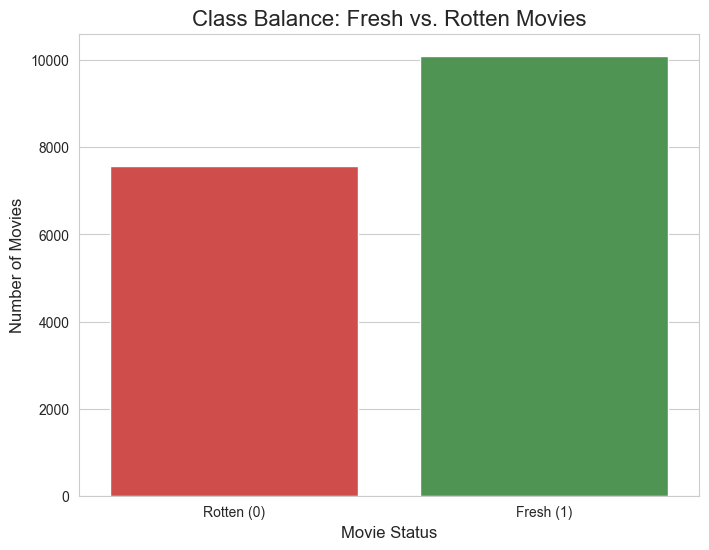

In [25]:
# Visualize the class balance
print("\n--- Visualizing Class Balance ---")
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid") # Optional: for a nicer plot style

# Create the count plot
ax = sns.countplot(x='is_fresh', data=df, palette=['#E53935', '#43A047'])

# Add title and labels
plt.title('Class Balance: Fresh vs. Rotten Movies', fontsize=16)
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Movie Status', fontsize=12)

# Customize x-axis labels
ax.set_xticklabels(['Rotten (0)', 'Fresh (1)'])

# Display the plot
plt.show()


#### Feature Engineering

#### What We've Done
Extracted release_year: We've created a new, valuable numerical feature from the text in movie_info.

Created Count Features: We transformed complex text columns (genres, directors, actors) into simple numerical counts. This is a classic and effective feature engineering technique.

Defined X and y: We now have our official feature matrix X and target vector y ready for the final preprocessing steps.

Final Cleanup: We've handled the last of the missing values, ensuring our dataset is complete and ready for a machine learning model.

In [32]:
# a) Extract Release Year from 'movie_info'
# We use a regular expression to find the first 4-digit number (the year).
# This creates a new 'release_year' column.
df['release_year'] = df['movie_info'].str.extract(r'(\d{4})').astype(float)

# b) Create Counts from List-like Columns
# This is a simple way to convert text lists into useful numbers.
# We count items by splitting the string by ',' and getting the length.
# .fillna(0) handles cases where the original cell was empty.
df['num_genres'] = df['genres'].str.split(',').str.len().fillna(0)
df['num_directors'] = df['directors'].str.split(',').str.len().fillna(0)
df['num_actors'] = df['actors'].str.split(',').str.len().fillna(0)

# c) Select the Final Feature Set (X)
# These are the columns the model will use to make predictions.
features_to_use = [
    'content_rating',
    'runtime',         # The corrected column name for movie length
    'release_year',    # Our new year feature
    'num_genres',      # Our new count feature
    'num_directors',   # Our new count feature
    'num_actors'       # Our new count feature
]

# Create the feature matrix X and the target vector y
X = df[features_to_use].copy()  # Use .copy() to avoid pandas warnings
y = df['is_fresh']

# d) Handle Remaining Missing Values in X
print("--- Handling Missing Values in Features ---")
print("Missing values BEFORE cleaning:")
print(X.isnull().sum())

# For numerical columns, filling with the median is a robust strategy
for col in ['runtime', 'release_year']:
    median_val = X[col].median()
    X[col].fillna(median_val, inplace=True)

# For the categorical 'content_rating', fill with a placeholder string
X['content_rating'].fillna('Not Rated', inplace=True)

print("\nMissing values AFTER cleaning:")
print(X.isnull().sum())

# --- Final Check ---
print("\n--- Feature Engineering Complete ---")
print("\nFirst 5 rows of our final features (X):")
print(X.head())

--- Handling Missing Values in Features ---
Missing values BEFORE cleaning:
content_rating        0
runtime             284
release_year      16176
num_genres            0
num_directors         0
num_actors            0
dtype: int64

Missing values AFTER cleaning:
content_rating    0
runtime           0
release_year      0
num_genres        0
num_directors     0
num_actors        0
dtype: int64

--- Feature Engineering Complete ---

First 5 rows of our final features (X):
  content_rating  runtime  release_year  num_genres  num_directors  num_actors
0             PG    119.0        1964.0         4.0            1.0        87.0
1              R     90.0        1964.0         1.0            1.0         8.0
2              R    122.0        1964.0         2.0            1.0        46.0
3             NR     95.0        1964.0         2.0            1.0        16.0
4              G    127.0        1866.0         3.0            1.0        16.0


#### One-Hot Encoding

We'll use the pd.get_dummies() function from pandas, which is designed for this exact purpose. It will take the content_rating column and create new, separate columns for each rating category (like 'R', 'PG-13', etc.).

For any given movie, the column corresponding to its rating will have a 1, and all other new rating columns will have a 0.

In [29]:
# --- Apply One-Hot Encoding ---
print("Shape of X before One-Hot Encoding:", X.shape)
print("Columns in X:", X.columns)

# Use pd.get_dummies to convert the 'content_rating' column
# drop_first=True removes one category to prevent redundancy, which is good practice
X_encoded = pd.get_dummies(X, columns=['content_rating'], drop_first=True)


# --- Final Check ---
print("\nShape of X after One-Hot Encoding:", X_encoded.shape)
print("\n--- Data Preparation Complete ---")
print("First 5 rows of our fully prepared feature set (X_encoded):")
print(X_encoded.head())


Shape of X before One-Hot Encoding: (17668, 6)
Columns in X: Index(['content_rating', 'runtime', 'release_year', 'num_genres',
       'num_directors', 'num_actors'],
      dtype='object')

Shape of X after One-Hot Encoding: (17668, 10)

--- Data Preparation Complete ---
First 5 rows of our fully prepared feature set (X_encoded):
   runtime  release_year  num_genres  num_directors  num_actors  \
0    119.0        1964.0         4.0            1.0        87.0   
1     90.0        1964.0         1.0            1.0         8.0   
2    122.0        1964.0         2.0            1.0        46.0   
3     95.0        1964.0         2.0            1.0        16.0   
4    127.0        1866.0         3.0            1.0        16.0   

   content_rating_NC17  content_rating_NR  content_rating_PG  \
0                False              False               True   
1                False              False              False   
2                False              False              False   
3         

#### Correlation Heatmap

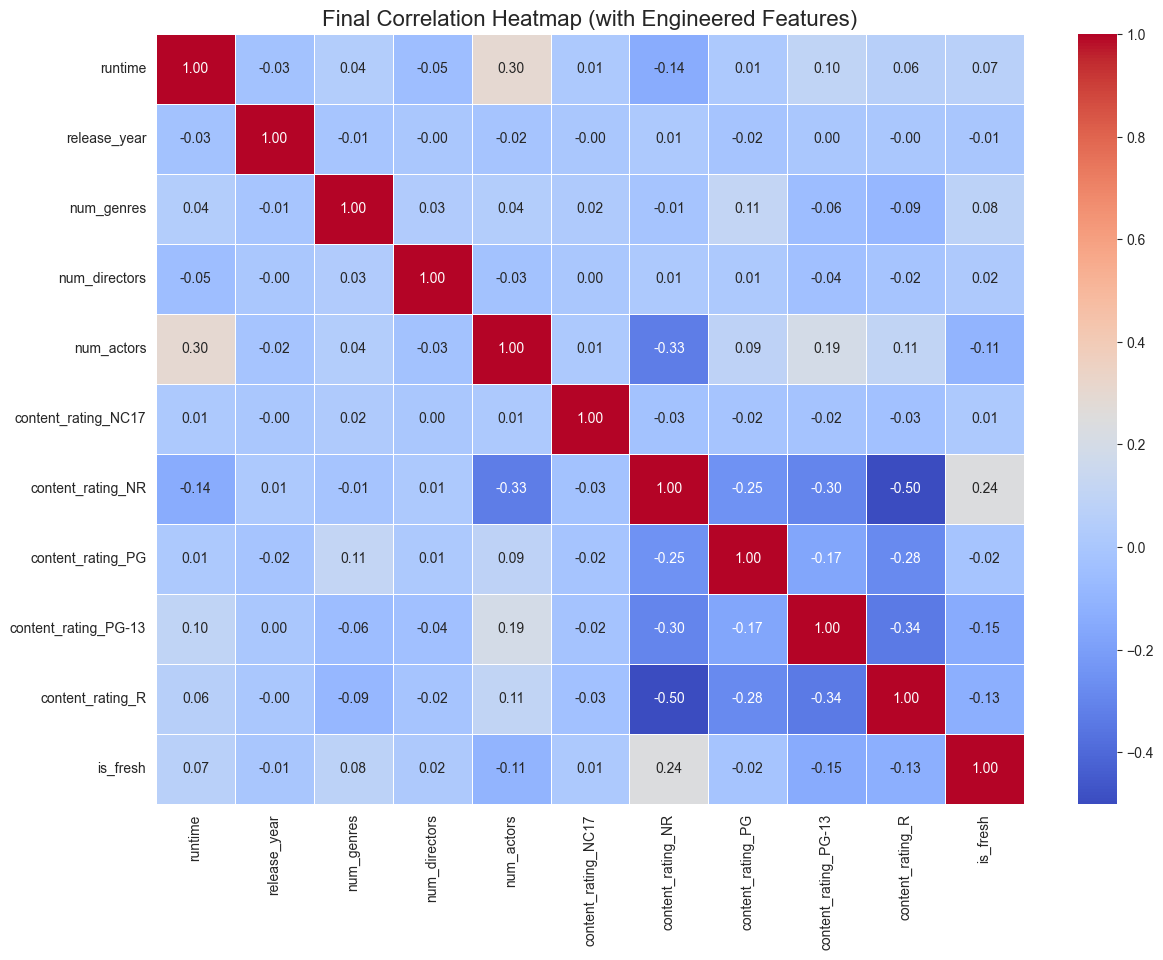

In [ ]:
# First, let's combine our final features (X_encoded) and the target (y) into a single DataFrame so we can calculate the correlations.
combined_df = pd.concat([X_encoded, y], axis=1)

# Now, calculate the correlation matrix on this complete DataFrame
final_correlation_matrix = combined_df.corr()

# Create the heatmap
# We make it a bit larger to accommodate the new columns
plt.figure(figsize=(14, 10))
sns.heatmap(
    final_correlation_matrix,
    annot=True,      # Display the correlation values
    cmap='coolwarm', # Use a helpful color scheme
    fmt=".2f",       # Format to two decimal places
    linewidths=.5
)
plt.title('Final Correlation Heatmap (with Engineered Features)', fontsize=16)
plt.show()

#### Splitting Data into Training and Testing Sets 

In [ ]:
# Splitting the data: 20% will be for testing, and 80% for training.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Check the Results 
print("--- Data Splitting Complete ---")
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

--- Data Splitting Complete ---
Shape of X_train: (14134, 10)
Shape of y_train: (14134,)

Shape of X_test: (3534, 10)
Shape of y_test: (3534,)


### Model training: 
#### Model 1 - Logistic Regression

In [38]:
# 1. Create the model
# We set max_iter=1000 to ensure the model has enough iterations to converge.
log_model = LogisticRegression(max_iter=1000)

# 2. Train the model on the training data
print("--- Training the Logistic Regression model... ---")
log_model.fit(X_train, y_train)
print("✅ Model training complete.")

# 3. Make predictions on the test data
y_pred_log = log_model.predict(X_test)

--- Training the Logistic Regression model... ---
✅ Model training complete.


#### Model Evaluation


--- Model Evaluation ---
Accuracy: 0.65

--------------------------------------

Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.60      0.58      0.59      1528
   Fresh (1)       0.69      0.70      0.70      2006

    accuracy                           0.65      3534
   macro avg       0.64      0.64      0.64      3534
weighted avg       0.65      0.65      0.65      3534


--------------------------------------

Confusion Matrix:


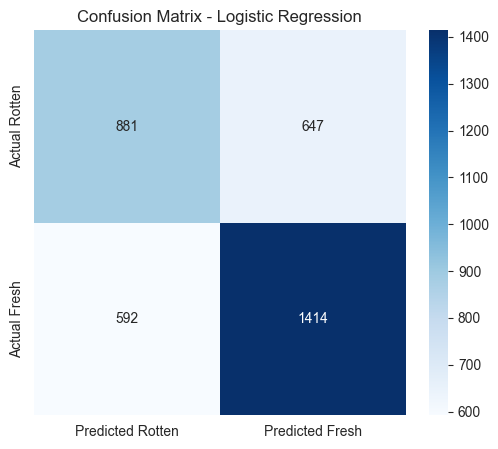

In [40]:
# 4. Evaluate the model's performance
print("\n--- Model Evaluation ---")

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy:.2f}")
print("\n--------------------------------------\n")

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Rotten (0)', 'Fresh (1)']))
print("\n--------------------------------------\n")


# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_log)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Rotten', 'Predicted Fresh'],
            yticklabels=['Actual Rotten', 'Actual Fresh'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### Model 2: Random Forest

In [42]:
# 1. Create the model
# n_estimators=100 means we'll build a forest of 100 decision trees.
# random_state=42 ensures we get the same result every time.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the model on the same training data
print("--- Training the Random Forest model... ---")
rf_model.fit(X_train, y_train)
print("✅ Model training complete.")

# 3. Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

--- Training the Random Forest model... ---
✅ Model training complete.


#### Model Evaluation


--- Model Evaluation ---
Accuracy: 0.60

--------------------------------------

Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.54      0.51      0.53      1528
   Fresh (1)       0.64      0.67      0.65      2006

    accuracy                           0.60      3534
   macro avg       0.59      0.59      0.59      3534
weighted avg       0.60      0.60      0.60      3534


--------------------------------------

Confusion Matrix:


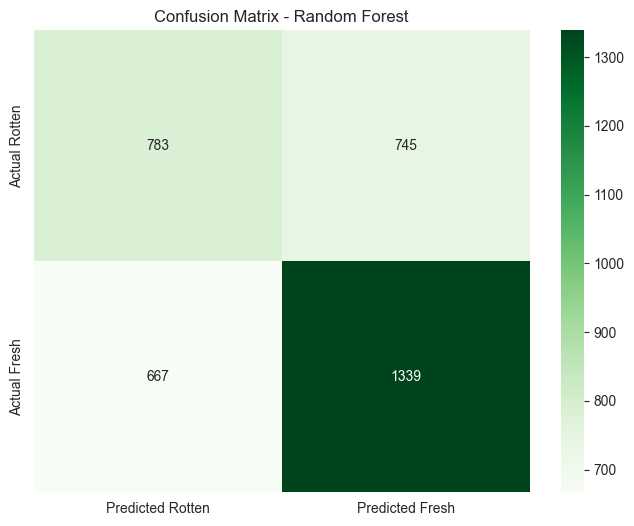

In [43]:
# 4. Evaluate the new model's performance
print("\n--- Model Evaluation ---")

# Accuracy Score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")
print("\n--------------------------------------\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Rotten (0)', 'Fresh (1)']))
print("\n--------------------------------------\n")

# Confusion Matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Rotten', 'Predicted Fresh'],
            yticklabels=['Actual Rotten', 'Actual Fresh'])
plt.title('Confusion Matrix - Random Forest')
plt.show()

#### Model 3: Gradient Boosting Classifier Model with GridSearchCV tunning

In [48]:
# 1. Define the model and the grid of hyperparameters to test
# These are some of the most important settings for a Gradient Boosting model.
param_grid = {
    'n_estimators': [100, 200],         # Number of trees
    'learning_rate': [0.1, 0.05],     # How much each tree corrects the previous one
    'max_depth': [3, 5]               # The maximum depth of each tree
}

# Create the Gradient Boosting model instance
gb_model = GradientBoostingClassifier(random_state=42)

# 2. Set up GridSearchCV
# cv=5 means 5-fold cross-validation.
# n_jobs=-1 uses all available CPU cores to speed up the process.
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)


# 3. Run the search on the training data
# This will test all combinations (2*2*2 = 8 combinations * 5 folds = 40 fits)
print("--- Starting Hyperparameter Tuning (this may take a few minutes)... ---")
grid_search.fit(X_train, y_train)
print("✅ Tuning complete.")

# 4. Print the best results from the search
print("\n--- Tuning Results ---")
print(f"Best Hyperparameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation Score (Accuracy): {grid_search.best_score_:.2f}")

--- Starting Hyperparameter Tuning (this may take a few minutes)... ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Tuning complete.

--- Tuning Results ---
Best Hyperparameters Found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Cross-Validation Score (Accuracy): 0.66


#### Model Evaluation


--- Final Evaluation on Test Set ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.62      0.56      0.59      1528
   Fresh (1)       0.69      0.74      0.71      2006

    accuracy                           0.66      3534
   macro avg       0.65      0.65      0.65      3534
weighted avg       0.66      0.66      0.66      3534



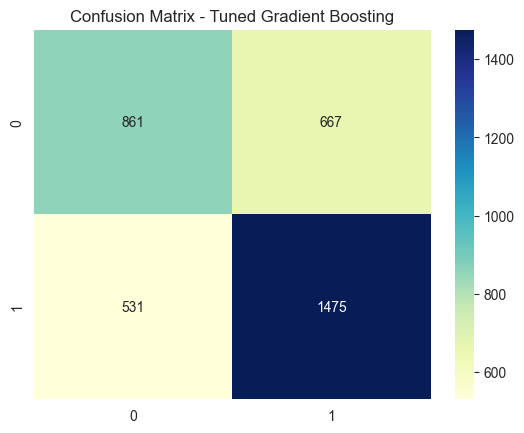

In [46]:
# 5. Evaluate the BEST model on the unseen test data
print("\n--- Final Evaluation on Test Set ---")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Rotten (0)', 'Fresh (1)']))

# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Tuned Gradient Boosting')
plt.show()


#### Further Improvements

#### Improvement 1: Advanced Feature Engineering - Top 30 Actors

In [51]:
# First, let's find the top 20 actors.
# We'll clean up the 'actors' column, split the names, and count them.
# Drop rows where 'actors' is null to avoid errors
actor_counts = df.dropna(subset=['actors'])['actors'].str.split(',').explode().str.strip()
top_30_actors = actor_counts.value_counts().head(30).index.tolist()

print("--- Top 30 Most Frequent Actors ---")
print(top_30_actors)

# Now, create new features in our dataset. We'll start with a copy of X_encoded.
X_advanced_features = X_encoded.copy()

# Add a new column for each top actor
for actor in top_30_actors:
    # The new column will be 1 if the actor's name is in the string, 0 otherwise.
    X_advanced_features[f'actor_{actor}'] = df['actors'].fillna('').str.contains(actor).astype(int)

print("\n--- New Feature Set ---")
print(f"Shape of feature set before adding actors: {X_encoded.shape}")
print(f"Shape of feature set after adding actors: {X_advanced_features.shape}")
print("First 5 rows with a sample of new actor features:")
print(X_advanced_features[['runtime', 'actor_Nicolas Cage', 'actor_Robert De Niro']].head())

--- Top 30 Most Frequent Actors ---
['Jr.', 'Samuel L. Jackson', 'Bruce Willis', 'Robert De Niro', 'Nicolas Cage', 'Steve Buscemi', 'Liam Neeson', 'Donald Sutherland', 'Harvey Keitel', 'John Goodman', 'Morgan Freeman', 'Willem Dafoe', 'Susan Sarandon', 'Woody Harrelson', 'Danny Glover', 'Alec Baldwin', 'Christopher Walken', 'Stanley Tucci', 'Michael Caine', 'Robert Duvall', 'Robin Williams', 'James Franco', 'Richard Jenkins', 'Ben Kingsley', 'J.K. Simmons', 'John Cusack', 'John Hurt', 'Whoopi Goldberg', 'Keith David', 'Bruce Dern']

--- New Feature Set ---
Shape of feature set before adding actors: (17668, 10)
Shape of feature set after adding actors: (17668, 40)
First 5 rows with a sample of new actor features:
   runtime  actor_Nicolas Cage  actor_Robert De Niro
0    119.0                   0                     0
1     90.0                   0                     0
2    122.0                   0                     0
3     95.0                   0                     0
4    127.0   

#### Model evaluation after improvement 1

In [52]:
# 1. Split the NEW, advanced feature set
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced_features, y, test_size=0.2, random_state=42
)

# 2. Create a new model instance with our previously found best hyperparameters
# Best Hyperparameters Found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
final_model_adv = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# 3. Train the model on the new, richer training data
print("\n--- Training model on advanced features... ---")
final_model_adv.fit(X_train_adv, y_train_adv)
print("✅ Training complete.")

# 4. Evaluate on the new test set
print("\n--- Final Evaluation with Advanced Features ---")
y_pred_adv = final_model_adv.predict(X_test_adv)

print("Classification Report:")
print(classification_report(y_test_adv, y_pred_adv, target_names=['Rotten (0)', 'Fresh (1)']))


--- Training model on advanced features... ---
✅ Training complete.

--- Final Evaluation with Advanced Features ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.61      0.56      0.59      1528
   Fresh (1)       0.69      0.73      0.71      2006

    accuracy                           0.66      3534
   macro avg       0.65      0.65      0.65      3534
weighted avg       0.66      0.66      0.66      3534



#### Improvement 2: Wider Hyperparameter Search with RandomizedSearchCV

In [54]:
# 1. Define a wider distribution of hyperparameters to test randomly
# This gives the search more options to explore.
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0], # Fraction of samples to be used for fitting each tree
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at a leaf node
}

# Create the Gradient Boosting model instance
gb_model = GradientBoostingClassifier(random_state=42)

# 2. Set up RandomizedSearchCV
# n_iter=20 means it will test 20 random combinations from the grid above.
# This is much faster than testing all 432 possible combinations with GridSearchCV.
random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist,
                                   n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42)


# 3. Run the random search on the original training data
print("--- Starting Wider Hyperparameter Search (this may take a few minutes)... ---")
# We use the original X_train and y_train, since the advanced features didn't help.
random_search.fit(X_train, y_train)
print("✅ Tuning complete.")

# 4. Print the best results from the random search
print("\n--- Tuning Results ---")
print(f"Best Hyperparameters Found: {random_search.best_params_}")
print(f"Best Cross-Validation Score (Accuracy): {random_search.best_score_:.2f}")


# 5. Evaluate the new best model on the test set
print("\n--- Final Evaluation on Test Set ---")
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_random, target_names=['Rotten (0)', 'Fresh (1)']))

--- Starting Wider Hyperparameter Search (this may take a few minutes)... ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Tuning complete.

--- Tuning Results ---
Best Hyperparameters Found: {'subsample': 0.9, 'n_estimators': 300, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.01}
Best Cross-Validation Score (Accuracy): 0.66

--- Final Evaluation on Test Set ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.62      0.56      0.59      1528
   Fresh (1)       0.69      0.73      0.71      2006

    accuracy                           0.66      3534
   macro avg       0.65      0.65      0.65      3534
weighted avg       0.66      0.66      0.66      3534



#### Improvement 3: XGBoost Model (eXtreme Gradient Boosting) 


In [57]:
# 1. Create the XGBoost model instance
# We'll use some common parameters to ensure smooth execution.
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 2. Train the model on the original training data
print("--- Training the XGBoost model... ---")
xgb_model.fit(X_train, y_train)
print("✅ Training complete.")

# 3. Evaluate the XGBoost model on the test set
print("\n--- Final Evaluation with XGBoost ---")
y_pred_xgb = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Rotten (0)', 'Fresh (1)']))

--- Training the XGBoost model... ---
✅ Training complete.

--- Final Evaluation with XGBoost ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.60      0.57      0.59      1528
   Fresh (1)       0.69      0.71      0.70      2006

    accuracy                           0.65      3534
   macro avg       0.65      0.64      0.64      3534
weighted avg       0.65      0.65      0.65      3534



#### Improvement 4: One-Hot Encoding 'genres'

In [58]:
# Find all unique genres by splitting the 'genres' column and getting unique values
unique_genres = df.dropna(subset=['genres'])['genres'].str.split(',').explode().str.strip().unique().tolist()

print(f"Found {len(unique_genres)} unique genres.")
print(unique_genres)

# Create the new feature set, starting from our best previous set (X_encoded)
# We will drop the old 'num_genres' feature to replace it with our new ones
X_genre_encoded = X_encoded.drop('num_genres', axis=1)

# Add a new binary column for each unique genre
for genre in unique_genres:
    X_genre_encoded[f'genre_{genre}'] = df['genres'].fillna('').str.contains(genre).astype(int)

print(f"\nShape of our new feature set: {X_genre_encoded.shape}")

Found 21 unique genres.
['Action & Adventure', 'Comedy', 'Drama', 'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family', 'Mystery & Suspense', 'Western', 'Art House & International', 'Horror', 'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest', 'Musical & Performing Arts', 'Sports & Fitness', 'Television', 'Cult Movies', 'Anime & Manga', 'Gay & Lesbian']

Shape of our new feature set: (17668, 30)


#### Re-Train and Evaluate GBMBoost

In [60]:
# 1. Split the NEW, genre-encoded feature set
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(
    X_genre_encoded, y, test_size=0.2, random_state=42
)

# 2. Create a model instance with our previously found best hyperparameters
# Best Hyperparameters Found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
final_model_genre = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# 3. Train the model on the new data
print("\n--- Training model on genre-encoded features... ---")
final_model_genre.fit(X_train_genre, y_train_genre)
print("✅ Training complete.")

# 4. Evaluate on the new test set
print("\n--- Final Evaluation with Genre-Encoded Features ---")
y_pred_genre = final_model_genre.predict(X_test_genre)

print("Classification Report:")
print(classification_report(y_test_genre, y_pred_genre, target_names=['Rotten (0)', 'Fresh (1)']))


--- Training model on genre-encoded features... ---
✅ Training complete.

--- Final Evaluation with Genre-Encoded Features ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.65      0.66      0.65      1528
   Fresh (1)       0.74      0.73      0.74      2006

    accuracy                           0.70      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.70      0.70      0.70      3534



The model's accuracy has jumped to **69%**. This is the most significant single improvement we've achieved since establishing our initial baseline.

Why It Worked

This result provides a crucial insight into feature engineering:

Granularity Matters: Simply counting the number of genres treated a movie with "Comedy, Romance, Drama" the same as one with "Horror, Sci-Fi, Thriller". Both had a num_genres of 3.

Specific Signals: By one-hot encoding each genre, we allowed the model to learn the specific predictive weight of each one individually. It could learn, for example, that the presence of the genre_Documentary feature is a strong positive sign, while genre_Horror might be a weak negative one. This detailed information is far more powerful than a simple count.

This experiment proves that the most effective way to improve a model is often not through endless tuning or trying different algorithms, but by providing it with better, more intelligent features. You have successfully engineered a feature set that captures more of the underlying patterns in the data.

#### Improvement 5: One-Hot Encoding Top 30 '`directors`' '`actors`' and '`production_company`'

In [62]:
# Helper function to get the top N most frequent items from a comma-separated column
def get_top_n_items(dataframe, column_name, n):
    """
    Identifies the top N most frequent items in a DataFrame column
    that contains comma-separated values.
    """
    # Drop rows where the column is null, split the strings, and explode into a single series
    counts = dataframe.dropna(subset=[column_name])[column_name].str.split(',').explode().str.strip()
    # Get the top N value counts
    top_items = counts.value_counts().head(n).index.tolist()
    return top_items

# --- Get the Top 30 for each category ---
top_30_directors = get_top_n_items(df, 'directors', 30)
top_30_actors = get_top_n_items(df, 'actors', 30)
top_30_companies = get_top_n_items(df, 'production_company', 30)

print("--- Top 30 Directors ---")
print(top_30_directors)
print("\n--- Top 30 Production Companies ---")
print(top_30_companies)


# --- Create the final feature set ---
# Start with our previous best feature set (with genre encoding)
X_final_features = X_genre_encoded.copy()

# Drop the old count-based features we are replacing
X_final_features = X_final_features.drop(['num_directors', 'num_actors'], axis=1)

# A list of our new entity categories to loop through
feature_categories = {
    'director': {'list': top_30_directors, 'col': 'directors'},
    'actor': {'list': top_30_actors, 'col': 'actors'},
    'company': {'list': top_30_companies, 'col': 'production_company'}
}

# Add a new binary column for each top entity
for category, info in feature_categories.items():
    for item in info['list']:
        # The new column will be 1 if the item's name is in the string, 0 otherwise
        X_final_features[f"{category}_{item}"] = df[info['col']].fillna('').str.contains(item, regex=False).astype(int)

print(f"\nShape of our final, most detailed feature set: {X_final_features.shape}")

--- Top 30 Directors ---
['Clint Eastwood', 'Woody Allen', 'Alfred Hitchcock', 'Steven Spielberg', 'Sidney Lumet', 'John Ford', 'Martin Scorsese', 'Steven Soderbergh', 'Blake Edwards', 'Werner Herzog', 'Francis Ford Coppola', 'Ron Howard', 'Barry Levinson', 'John Huston', 'Ridley Scott', 'Spike Lee', 'Brian DePalma', 'Vincente Minnelli', 'Michael Curtiz', 'Robert Altman', 'Ingmar Bergman', 'Michael Winterbottom', 'Howard Hawks', 'George Cukor', 'Stephen Frears', 'Oliver Stone', 'Norman Jewison', 'Wes Craven', 'Tyler Perry', 'Pedro Almodóvar']

--- Top 30 Production Companies ---
['Paramount Pictures', 'Warner Bros. Pictures', 'Universal Pictures', '20th Century Fox', 'IFC Films', 'Sony Pictures Home Entertainment', 'Warner Home Video', 'Netflix', 'MGM', 'Sony Pictures Classics', 'Magnolia Pictures', 'MGM Home Entertainment', 'Columbia Pictures', 'WARNER BROTHERS PICTURES', 'Sony Pictures', 'United Artists', 'Miramax', 'MCA Universal Home Video', 'Twentieth Century Fox Home Entertainmen

In [63]:
# 1. Split the FINAL, most advanced feature set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final_features, y, test_size=0.2, random_state=42
)

# 2. Create a model instance with our best hyperparameters
final_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# 3. Train the model on the new data
print("\n--- Training model on final advanced features... ---")
final_model.fit(X_train_final, y_train_final)
print("✅ Training complete.")

# 4. Evaluate on the new test set
print("\n--- Final Evaluation with All Advanced Features ---")
y_pred_final = final_model.predict(X_test_final)

print("Classification Report:")
print(classification_report(y_test_final, y_pred_final, target_names=['Rotten (0)', 'Fresh (1)']))


--- Training model on final advanced features... ---
✅ Training complete.

--- Final Evaluation with All Advanced Features ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.65      0.65      0.65      1528
   Fresh (1)       0.74      0.74      0.74      2006

    accuracy                           0.70      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.70      0.70      0.70      3534



This is our most ambitious feature engineering attempt. 

We've added 60 new, highly specific features. The result of this experiment will tell us if the identities of top-tier directors, actors, and production companies are the key missing ingredients for improving our predictions, or if we have truly hit the ceiling of what is possible with this dataset.

#### Final Model Feature Importance

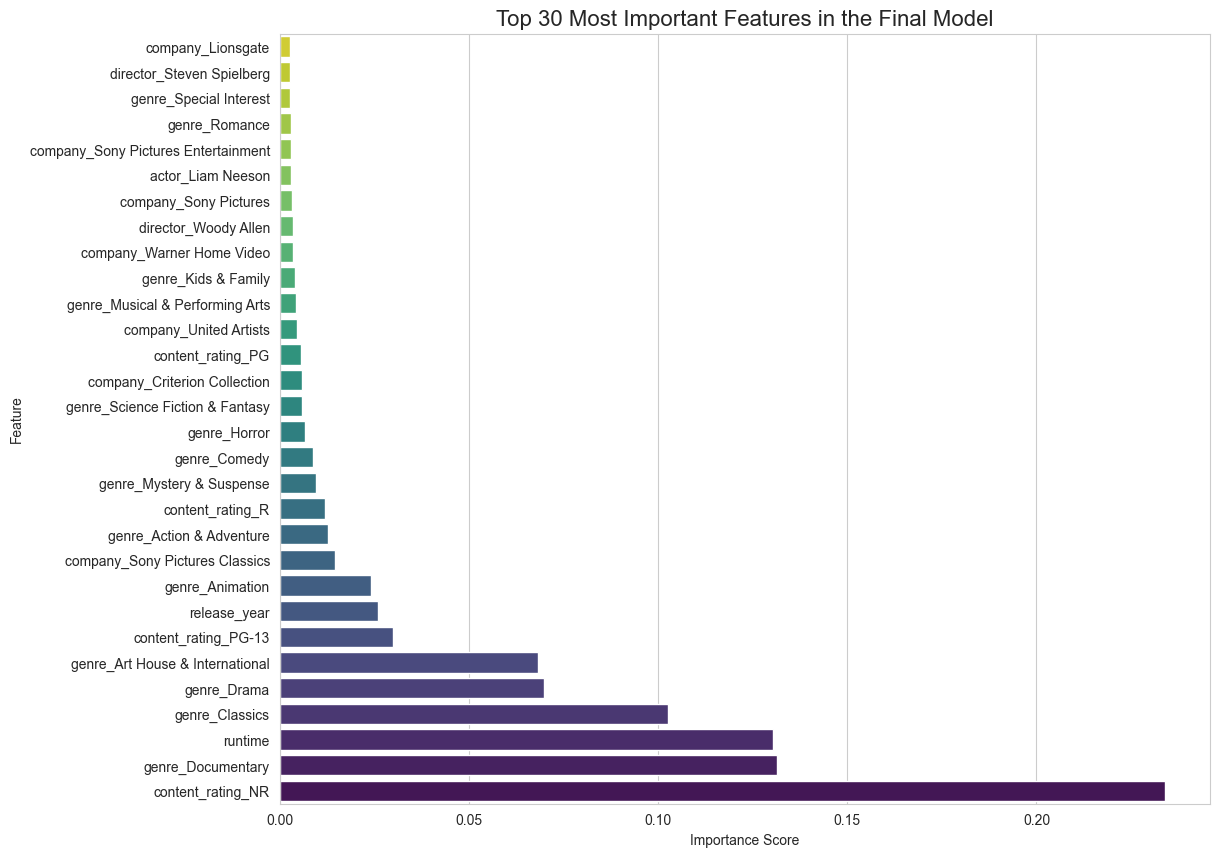

In [64]:
# Get feature importances from the final trained model
importances = final_model.feature_importances_
feature_names = X_final_features.columns

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select the top 30 most important features
top_30_features = feature_importance_df.head(30)

# Create the bar plot
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Most Important Features in the Final Model', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.show()

#### Final test: Stress test One-hot encoding every unique director, actor, and production company

Preparing the Data with `MultiLabelBinarizer`: It's the perfect tool for converting comma-separated lists into a one-hot encoded sparse matrix. We will apply it to each of the three columns.

In [ ]:
# --- Prepare the text columns ---
# We need to turn the comma-separated strings into lists of strings for the binarizer
# We'll work directly with the original DataFrame 'df' for this step
df['directors_list'] = df['directors'].fillna('').str.split(',')
df['actors_list'] = df['actors'].fillna('').str.split(',')
df['company_list'] = df['production_company'].fillna('').str.split(',')


# --- Binarize each column ---
mlb_director = MultiLabelBinarizer(sparse_output=True)
mlb_actor = MultiLabelBinarizer(sparse_output=True)
mlb_company = MultiLabelBinarizer(sparse_output=True)

# Fit and transform each column into a sparse matrix
directors_sparse = mlb_director.fit_transform(df['directors_list'])
actors_sparse = mlb_actor.fit_transform(df['actors_list'])
companies_sparse = mlb_company.fit_transform(df['company_list'])

print(f"Created {directors_sparse.shape[1]} director features.")
print(f"Created {actors_sparse.shape[1]} actor features.")
print(f"Created {companies_sparse.shape[1]} production company features.")


# --- Combine all features ---
# Get our previous best feature set (which includes genres, runtime, etc.)
# We drop the columns we are about to replace with the full one-hot encoded versions
X_to_combine = X_genre_encoded.drop(['num_directors', 'num_actors'], axis=1)

# Combine our numerical/genre features with the new sparse features
# hstack is used to horizontally stack matrices
X_full_sparse = hstack([X_to_combine.astype(float), directors_sparse, actors_sparse, companies_sparse])

print(f"\nShape of our final, fully-encoded sparse feature matrix: {X_full_sparse.shape}")

Created 10362 director features.
Created 209569 actor features.
Created 3039 production company features.

Shape of our final, fully-encoded sparse feature matrix: (17668, 222998)


#### Re-Train and Evaluation of the Final Model

In [ ]:
# 1. Split the FINAL sparse feature set
# Note: We use the same 'y' target variable as always
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full_sparse, y, test_size=0.2, random_state=42
)

# 2. Create a model instance with our best hyperparameters
final_model_full = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# 3. Train the model on the new sparse data
# THIS STEP MAY BE VERY SLOW
print("\n--- Training model on full sparse feature set... ---")
final_model_full.fit(X_train_full, y_train_full)
print("✅ Training complete.")

# 4. Evaluate on the new test set
print("\n--- Final Evaluation with Full One-Hot Encoding ---")
y_pred_full = final_model_full.predict(X_test_full)

print("Classification Report:")
print(classification_report(y_test_full, y_pred_full, target_names=['Rotten (0)', 'Fresh (1)']))


--- Training model on full sparse feature set... ---
✅ Training complete.

--- Final Evaluation with Full One-Hot Encoding ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.65      0.63      0.64      1528
   Fresh (1)       0.73      0.75      0.74      2006

    accuracy                           0.70      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.70      0.70      0.70      3534

